In [1]:
import webdataset as wds
import wids
import jax
import jax.numpy as jnp
import torch
import augmax
import matplotlib.pyplot as plt

import torchvision.transforms.v2 as tv
import grain.python as pygrain
from typing import Any, Dict, List, Tuple
import numpy as np
from torch.utils.data import DataLoader as TorchDataLoader, default_collate
from functools import partial
import tqdm

import fsspec
import json

import os
from transformers import AutoTokenizer, FlaxCLIPTextModel, CLIPTextModel

/home/mrwhite0racle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

In [61]:
jax.process_index(), jax.process_count()

(0, 1)

In [4]:
denormalizeImage = lambda x: (x + 1.0) * 127.5

def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()


In [5]:
def flaxTextEncodeModel():
    modelname = "openai/clip-vit-large-patch14"
    model = FlaxCLIPTextModel.from_pretrained(modelname, dtype=jnp.float16)
    tokenizer = AutoTokenizer.from_pretrained(modelname, dtype=jnp.float16)
    return model, tokenizer

def torchTextEncodeModel():
    modelname = "openai/clip-vit-large-patch14"
    model = CLIPTextModel.from_pretrained(modelname)
    tokenizer = AutoTokenizer.from_pretrained(modelname)
    return model, tokenizer

def encodePrompts(prompts, model, tokenizer=None):
    if model == None:
        model, tokenizer = flaxTextEncodeModel()
    if tokenizer == None:
        tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    # inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")
    inputs = tokenizer(prompts, padding="max_length", max_length=12, truncation=True, return_tensors="np")

    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    pooler_output = outputs.pooler_output  # pooled (EOS token) states
    embed_pooled = pooler_output.astype(jnp.float16)
    embed_labels_full = last_hidden_state.astype(jnp.float16)
    
    return embed_pooled, embed_labels_full

In [6]:
class CaptionProcessor:
    def __init__(self, tensor_type="pt", modelname="openai/clip-vit-large-patch14"):
        self.tokenizer = AutoTokenizer.from_pretrained(modelname)
        self.tensor_type = tensor_type
        
    def __call__(self, json_data: Dict[str, Any]):
        # Given a caption string, generate clip embeddings for it
        caption = json_data['caption']
        tokens = self.tokenizer(caption, padding="max_length", max_length=self.tokenizer.model_max_length, truncation=True, return_tensors=self.tensor_type)
        return {
            "input_ids": tokens["input_ids"].squeeze(),
            "attention_mask": tokens["attention_mask"].squeeze(),
            "caption": caption,
        }
        
    def __repr__(self):
        return self.__class__.__name__ + '()'

def get_torch_dataloader(source_url: str = "gs://flaxdiff-datasets/webdatasets/cc12m/{00000..01242}.tar", 
                         batch_size: int = 64, image_size: int = 256, 
                         num_workers: int = 64, prefetch_factor: int = 100):

    class Preprocess:
        def __call__(self, x):
            x = x.permute(1, 2, 0)
            x = (x / 127.5) - 1.0
            return x

        def __repr__(self):
            return self.__class__.__name__ + '()'

    train_transforms = tv.Compose([
        tv.Resize(image_size, interpolation=3),
        tv.RandomCrop(image_size, padding=4, padding_mode="reflect"),
        tv.RandomHorizontalFlip(),
        # tv.ColorJitter(args.color_jitter, args.color_jitter, args.color_jitter),
        # tv.RandomErasing(args.random_erasing, value="random"),
        tv.PILToTensor(),
        Preprocess(),
    ])

    def collate_and_shuffle(batch: list[Any], repeats: int = 1) -> Any:
        return default_collate(sum([batch[i::repeats] for i in range(repeats)], []))

    dataset = wds.DataPipeline(
        wds.SimpleShardList(source_url, seed=0),
        
        wds.shuffle(100),
        wds.split_by_worker,
        wds.tarfile_to_samples(handler=wds.ignore_and_continue),
        wds.shuffle(1000),
        # this decodes the images and json
        wds.decode("pil", handler=wds.ignore_and_continue),
        wds.to_tuple("jpg", "json"),
        # wds.map(preprocess_sample),
        wds.map_tuple(train_transforms, CaptionProcessor()),
    )
    train_dataloader = TorchDataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=partial(collate_and_shuffle, repeats=2),
        drop_last=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True,
    )
    return train_dataloader

In [7]:
train_dataloader = get_torch_dataloader(num_workers=64)
dataset = iter(train_dataloader)

for _ in tqdm.tqdm(range(1000)):
    batch = next(dataset)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.64it/s]


Process Process-55:
Process Process-34:
Process Process-63:
Process Process-49:
Process Process-56:
Process Process-59:
Process Process-52:
Process Process-41:
Process Process-51:
Process Process-48:
Process Process-36:
Process Process-64:
Process Process-32:
Process Process-27:
Process Process-7:
Process Process-12:
Process Process-29:
Process Process-50:
Process Process-62:
Process Process-44:
Process Process-26:
Process Process-40:
Process Process-13:
Process Process-53:
Process Process-38:
Process Process-31:
Process Process-45:
Process Process-22:
Process Process-28:
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Process Process-1:
Process Process-57:
Process Process-43:
Process Process-20:
Process Process-6:
Process Process-58:
Process Process-23:
Process Process-61:
Process Process-14:
Process Pro

# Make a WID compatible json descriptor for the dataset

In [8]:
def get_dataset_stats(source_url: str = "gs://flaxdiff-datasets/webdatasets/cc12m/", output_dir: str='./') -> str:
    """
    Dataset descriptions are JSON files. They must have the following format;

    {
        "wids_version": 1,
        # optional immediate shardlist
        "shardlist": [
            {"url": "http://example.com/file.tar", "nsamples": 1000},
            ...
        ],
        # sub-datasets
        "datasets": [
            {"source_url": "http://example.com/dataset.json"},
            {"shardlist": [
                {"url": "http://example.com/file.tar", "nsamples": 1000},
                ...
            ]}
            ...
        ]
    }
    """
    # First read all the json stats files in the dataset
    fs, output_path = fsspec.core.url_to_fs(source_url, use_listings_cache=False)
    stats_files = [i for i in fs.glob(output_path + "*.json") if 'global' not in i]
        
    wids_shardlist = []
    total_samples = 0

    for stats_file in tqdm.tqdm(stats_files):
        with fs.open(stats_file, "r") as f:
            try:
                stats = json.load(f)
                shard_name = stats_file.replace("_stats.json", ".tar")
                shard_name = shard_name.split("/")[-1]
                nsamples = stats["successes"]
                total_samples += nsamples
                wids_shardlist.append({"url": shard_name, "nsamples": nsamples})
            except Exception as err:  # pylint: disable=broad-except
                    print(f"failed to parse stats file {stats_file}", err)
    wids_stats = {"wids_version": 1, "shardlist": wids_shardlist}
    
    # Save the global stats in the source_url
    global_stats_file = os.path.join(output_dir, "global_stats/global_stats.json")
    with fsspec.open(global_stats_file, "w") as f:
        json.dump(wids_stats, f)
        
    return global_stats_file, wids_shardlist, total_samples

In [9]:
global_stats_file, wids_shardlist, total_samples = get_dataset_stats("gs://flaxdiff-datasets/arrayrecord/cc12m/")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1243/1243 [01:37<00:00, 12.76it/s]


In [10]:
total_samples

8329829

In [43]:
global_stats_file = "gs://flaxdiff-datasets/webdatasets/cc12m/global_stats/global_stats.json"
data_source = wids.ShardListDataset(global_stats_file, base="gs://flaxdiff-datasets/webdatasets/cc12m/", cache_size=10)

Copying gs://flaxdiff-datasets/webdatasets/cc12m/global_stats/global_stats.json...
/ [1 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 1 objects/48.6 KiB.                                     
gs://flaxdiff-datasets/webdatasets/cc12m/global_st base: gs://flaxdiff-datasets/webdatasets/cc12m/ name: None nfiles: 1243 nbytes: 0 samples: 8408499 cache: /tmp/_wids_cache


In [ ]:
data_source[1]

Copying gs://flaxdiff-datasets/webdatasets/cc12m/00000.tar...
| [1 files][178.7 MiB/178.7 MiB]                                                
Operation completed over 1 objects/178.7 MiB.                                    


{'.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 '.json': {'caption': 'Couple watching the sunset in the sea. Couple in love watching the colorful sunset in the sea stock images',
  'url': 'https://thumbs.dreamstime.com/b/couple-watching-sunset-sea-couple-love-watching-colorful-sunset-sea-161540574.jpg',
  'key': '000000117',
  'status': 'success',
  'error_message': None,
  'width': 256,
  'height': 256,
  'original_width': 800,
  'original_height': 534,
  'exif': '{"Image XResolution": "72", "Image YResolution": "72", "Image ResolutionUnit": "Pixels/Inch", "Image YCbCrPositioning": "Centered", "Image Copyright": "| Dreamstime.com"}'},
 '.txt': 'Couple watching the sunset in the sea. Couple in love watching the colorful sunset in the sea stock images',
 '__key__': '000000117',
 '__shard__': 'gs://flaxdiff-datasets/webdatasets/cc12m/00000.tar',
 '__shardindex__': 1,
 '__dataset__': None}

In [62]:
from array_record.python.array_record_module import ArrayRecordWriter

2024-07-31 15:38:39.853800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 15:38:39.868309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 15:38:39.873026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 15:38:40.700456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Experimentation with Array Records

In [191]:
import struct 

def pack_dict_of_byte_arrays(data_dict):
    """
    Pack a dictionary of byte arrays into a single byte array.
    
    Args:
        data_dict (dict): Dictionary where keys are strings and values are byte arrays.
        
    Returns:
        bytes: Packed byte array.
    """
    packed_data = bytearray()
    
    for key, byte_array in data_dict.items():
        # Ensure the key is a string
        if not isinstance(key, str):
            raise ValueError("Keys must be strings")
        
        # Convert the key to bytes
        key_bytes = key.encode('utf-8')
        
        # Pack the key length and key bytes
        packed_data.extend(struct.pack('I', len(key_bytes)))
        packed_data.extend(key_bytes)
        
        # Pack the byte array length and byte array
        packed_data.extend(struct.pack('I', len(byte_array)))
        packed_data.extend(byte_array)
    
    return bytes(packed_data)

def unpack_dict_of_byte_arrays(packed_data):
    """
    Unpack a single byte array into a dictionary of byte arrays.
    
    Args:
        packed_data (bytes): Packed byte array.
        
    Returns:
        dict: Dictionary where keys are strings and values are byte arrays.
    """
    unpacked_dict = {}
    offset = 0
    
    while offset < len(packed_data):
        # Unpack the key length
        key_length = struct.unpack_from('I', packed_data, offset)[0]
        offset += struct.calcsize('I')
        
        # Unpack the key bytes and convert to string
        key = packed_data[offset:offset+key_length].decode('utf-8')
        offset += key_length
        
        # Unpack the byte array length
        byte_array_length = struct.unpack_from('I', packed_data, offset)[0]
        offset += struct.calcsize('I')
        
        # Unpack the byte array
        byte_array = packed_data[offset:offset+byte_array_length]
        offset += byte_array_length
        
        unpacked_dict[key] = byte_array
    
    return unpacked_dict

class ArrayRecordSampleWriter:
    """ArrayRecordSampleWriter is a writer to ArrayRecord format"""

    def __init__(
        self,
        shard_id,
        output_folder,
        save_caption,
        oom_shard_count,
        schema,
        encode_format,
    ):
        self.oom_shard_count = oom_shard_count
        self.encode_format = encode_format
        self.save_caption = save_caption
        shard_name = "{shard_id:0{oom_shard_count}d}".format(  # pylint: disable=consider-using-f-string
            shard_id=shard_id, oom_shard_count=oom_shard_count
        )
        self.output_file = f"{output_folder}/{shard_name}.array_record"
        self.tmp_file = f"/tmp/{shard_name}.array_record"
        self.writer = ArrayRecordWriter(self.tmp_file, options=f"group_size:1")
        
    def write(self, img_str, key, caption, meta):
        """Write sample to ArrayRecord"""
        if img_str is not None:
            sample = {
                "key": self._bytes_feature(key.encode()),
                self.encode_format: self._bytes_feature(img_str),
            }
            if self.save_caption:
                sample["txt"] = caption.encode() if caption is not None else b""
            for k, v in meta.items():
                if isinstance(v, np.ndarray):
                    meta[k] = v.tolist()
            sample["meta"] = json.dumps(meta).encode()
            # tf_example = self._Example(features=self._Features(feature=sample))
            self.writer.write(pack_dict_of_byte_arrays(sample))
            
            
    def _bytes_feature(self, value):
        if value is None:
            value = ""
        if isinstance(value, str):
            value = value.encode()
        return value
        
    def close(self):
        self.writer.close()

In [192]:
a = ArrayRecordSampleWriter(0, "./", True, 5, "jpg", "jpg")

In [161]:
for i in tqdm.tqdm(range(0, 10000)):
    a.write(data_source[1]['.jpg'].tobytes(), 'key', 'caption', {'meta': 'data'})
a.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 555.74it/s]


In [93]:
for i in tqdm.tqdm(range(0, 10000)):
    a.write(data_source[1]['.jpg'].tobytes(), 'key', 'caption', {'meta': 'data'})
a.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 562.15it/s]


In [98]:
img = data_source[1]['.jpg']
image_data = img.tobytes()

In [87]:
import tensorflow as tf
import PIL

In [254]:
cc12m_records_path = "/home/mrwhite0racle/research/FlaxDiff/datasets/gcs_mount/arrayrecord/cc12m/"
cc12m_records = [os.path.join(cc12m_records_path, i) for i in os.listdir(cc12m_records_path) if 'array_record' in i]
ds = pygrain.ArrayRecordDataSource(cc12m_records)

class ParseFeatures(pygrain.MapTransform):
  def map(self, _features):
    _features = unpack_dict_of_byte_arrays(_features)
    image = np.asarray(bytearray(_features['jpg']), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    # image = PIL.Image.frombytes('RGB', (256,256), _features['jpg'], 'raw')
    # image = np.array(image)
    # image = (image / 127.5) - 1.0
    caption = _features['txt']
    return image, caption

sampler = pygrain.IndexSampler(
  num_records=8329829, 
  shard_options=pygrain.NoSharding(),
  seed=0,
  shuffle=True,
  )
loader = pygrain.DataLoader(
  data_source=ds,
  operations=[ParseFeatures(), pygrain.Batch(1)],
  sampler=sampler,
  worker_buffer_size=100,
    worker_count=4,
    read_options=pygrain.ReadOptions(64, 100),
)

In [255]:
dataset = iter(loader)

for _ in tqdm.tqdm(range(10000)):
    batch = next(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 801.81it/s]


In [226]:
batch['jpg']

SharedMemoryArray([b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x

In [243]:
image = np.asarray(bytearray(batch['jpg']), dtype="uint8")

ValueError: invalid literal for int() with base 10: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\

In [228]:
image

array([255, 216, 255, ...,  15, 255, 217], dtype=uint8)

In [230]:
import cv2

In [244]:
img = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

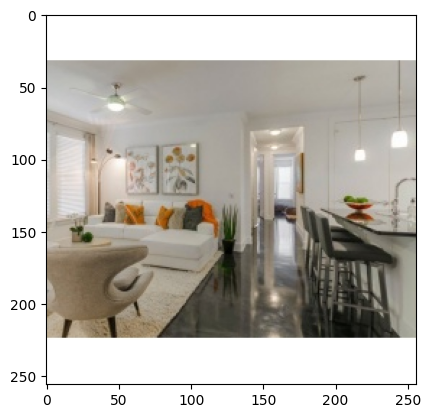

In [245]:
plt.imshow(img)